# YOLOv5 Face Mask Detection 🧪
This notebook walks through loading a trained YOLOv5 model and testing it on images.

In [39]:
import os
import shutil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import xml.etree.ElementTree as ET

from kaggle.api.kaggle_api_extended import KaggleApi
from sklearn.metrics import classification_report, confusion_matrix

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Input
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

import torch
# from PIL import Image
import glob

In [40]:
def download_dataset(kaggle_json_path, download_path="../data"):
    os.environ['KAGGLE_CONFIG_DIR'] = os.path.dirname(kaggle_json_path)
    api = KaggleApi()
    api.authenticate()
    api.dataset_download_files("andrewmvd/face-mask-detection", path=download_path, unzip=True)
    print("✅ Dataset downloaded and extracted to", download_path)

In [41]:
def organize_dataset(
    annotations_dir='../data/annotations',
    images_dir='../data/images',
    output_dir='../dataset'
):
    labels_map = {
        'with_mask': 'with_mask',
        'without_mask': 'without_mask',
        'mask_weared_incorrect': 'mask_weared_incorrect'
    }

    # Create a class folder if it doesn't already exist
    for label in labels_map.values():
        os.makedirs(os.path.join(output_dir, label), exist_ok=True)

    # Read the XML file and move the images to the class folder as labeled
    for xml_file in os.listdir(annotations_dir):
        if not xml_file.endswith('.xml'):
            continue

        xml_path = os.path.join(annotations_dir, xml_file)
        tree = ET.parse(xml_path)
        root = tree.getroot()

        filename = root.find('filename').text
        label = root.find('object').find('name').text

        if label in labels_map:
            src_image_path = os.path.join(images_dir, filename)
            dst_image_path = os.path.join(output_dir, labels_map[label], filename)

            if os.path.exists(src_image_path):
                shutil.copy(src_image_path, dst_image_path)

    print("✅ The dataset has been moved to the per-class folder in the:", output_dir)

In [42]:
# def create_model(input_shape=(224, 224, 3), num_classes=3):
#     model = Sequential([
#         Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
#         MaxPooling2D(2, 2),
#         Conv2D(64, (3, 3), activation='relu'),
#         MaxPooling2D(2, 2),
#         Conv2D(128, (3, 3), activation='relu'),
#         MaxPooling2D(2, 2),
#         Flatten(),
#         Dense(256, activation='relu'),
#         Dropout(0.5),
#         Dense(num_classes, activation='softmax')
#     ])
#     return model

def create_model(input_shape=(224, 224, 3), num_classes=3):
    base_model = MobileNetV2(weights='imagenet', include_top=False, input_tensor=Input(shape=input_shape))

    # Freeze base model
    # base_model.trainable = False
    base_model.trainable = True

    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.5)(x)
    outputs = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=outputs)
    return model

In [43]:
def plot_training(history):
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Acc')
    plt.plot(history.history['val_accuracy'], label='Val Acc')
    plt.legend()
    plt.title('Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.legend()
    plt.title('Loss')
    plt.show()

def evaluate_model(model, val_gen):
    val_gen.reset()
    preds = model.predict(val_gen, verbose=1)
    y_pred = np.argmax(preds, axis=1)
    y_true = val_gen.classes
    class_labels = list(val_gen.class_indices.keys())

    print("Classification Report:")
    print(classification_report(y_true, y_pred, target_names=class_labels))

    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=val_gen.class_indices, yticklabels=val_gen.class_indices)
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.title('Confusion Matrix')
    print("Confusion Matrix:")
    print(cm)
    
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
    plt.title("Normalized Confusion Matrix")


In [44]:
def save_predictions(y_true, y_pred, class_indices, file_path="../visualizations/predictions.csv"):
    class_labels = list(class_indices.keys())
    inverse_map = {v: k for k, v in class_indices.items()}

    df = pd.DataFrame({
        'Actual': [inverse_map[i] for i in y_true],
        'Predicted': [inverse_map[i] for i in y_pred]
    })

    df.to_csv(file_path, index=False)
    print(f"📄 Saved prediction results to {file_path}")

In [45]:
def predict_single_image(image_path, model, class_indices, img_size=(224, 224)):
    img = tf.keras.utils.load_img(image_path, target_size=img_size)
    img_array = tf.keras.utils.img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    prediction = model.predict(img_array)
    predicted_class = np.argmax(prediction)
    class_labels = list(class_indices.keys())

    print(f"📌 Image: {image_path}")
    print(f"Predicted: {class_labels[predicted_class]}")

In [46]:
# Download dataset
kaggle_json_path = "../kaggle.json"  # Adjust path if needed
if not os.path.exists("../data/annotations"):  # simple check if already extracted
    download_dataset(kaggle_json_path)

Dataset URL: https://www.kaggle.com/datasets/andrewmvd/face-mask-detection
✅ Dataset downloaded and extracted to ../data


In [47]:
# Preprocessing
organize_dataset()

img_size = (224, 224)
batch_size = 32

datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest",
    validation_split=0.2
)


train_gen = datagen.flow_from_directory(
    '../dataset/',  # fixed path
    target_size=img_size,
    batch_size=batch_size,
    subset='training',
    class_mode='categorical'
)

val_gen = datagen.flow_from_directory(
    '../dataset/',  # fixed path
    target_size=img_size,
    batch_size=batch_size,
    subset='validation',
    class_mode='categorical'
)

test_datagen = ImageDataGenerator(rescale=1./255)
test_gen = test_datagen.flow_from_directory(
    "../dataset/",
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

✅ The dataset has been moved to the per-class folder in the: ../dataset
Found 684 images belonging to 3 classes.
Found 169 images belonging to 3 classes.
Found 853 images belonging to 3 classes.


In [48]:
# Model
model = create_model(input_shape=img_size + (3,), num_classes=3)
# model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
# Recompile
model.compile(optimizer=tf.keras.optimizers.Adam(1e-5),  # gunakan learning rate kecil
              loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 112, 112, 32)         864       ['input_2[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 112, 112, 32)         128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 112, 112, 32)         0         ['bn_Conv1[0][0]']      

In [50]:
# Training
if not os.path.exists("../models"):
    os.makedirs("../models")
    
checkpoint_cb = ModelCheckpoint("../models/best_mask_detector.h5", save_best_only=True, monitor='val_accuracy', mode='max')
earlystop_cb = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)

# history = model.fit(train_gen, validation_data=val_gen, epochs=20)
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=3,
    callbacks=[checkpoint_cb, earlystop_cb]
)

model.save("../models/mask_detector.h5")

Epoch 1/3
22/22 [==============================] - ETA: 0s - loss: 1.8305 - accuracy: 0.2251

c:\Users\Ryan\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


22/22 [==============================] - 68s 3s/step - loss: 1.8305 - accuracy: 0.2251 - val_loss: 2.4677 - val_accuracy: 0.0769
Epoch 2/3
22/22 [==============================] - 60s 3s/step - loss: 1.6188 - accuracy: 0.2719 - val_loss: 2.7581 - val_accuracy: 0.0592
Epoch 3/3
22/22 [==============================] - 58s 3s/step - loss: 1.2734 - accuracy: 0.4284 - val_loss: 3.0283 - val_accuracy: 0.0592


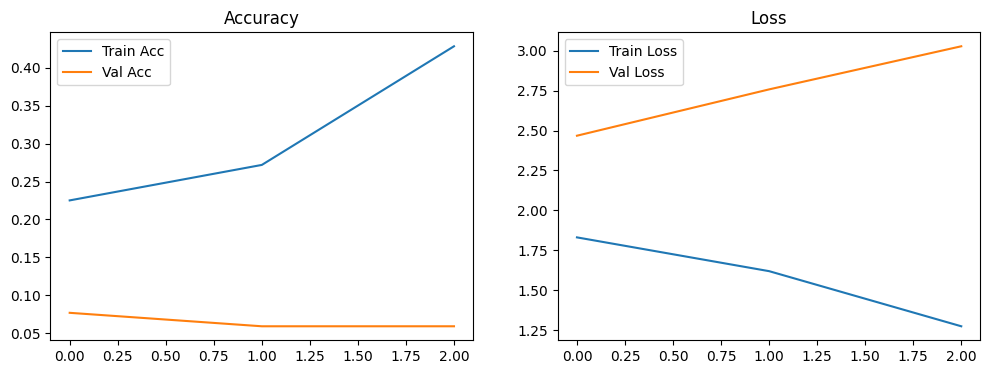

27/27 [==============================] - 19s 632ms/step
Classification Report:
                       precision    recall  f1-score   support

mask_weared_incorrect       0.04      0.64      0.07        36
            with_mask       1.00      0.02      0.04       698
         without_mask       0.11      0.23      0.15       119

             accuracy                           0.08       853
            macro avg       0.38      0.30      0.09       853
         weighted avg       0.83      0.08      0.06       853

Confusion Matrix:
[[ 23   0  13]
 [472  15 211]
 [ 92   0  27]]
27/27 [==============================] - 20s 726ms/step
📄 Saved prediction results to ../visualizations/predictions.csv


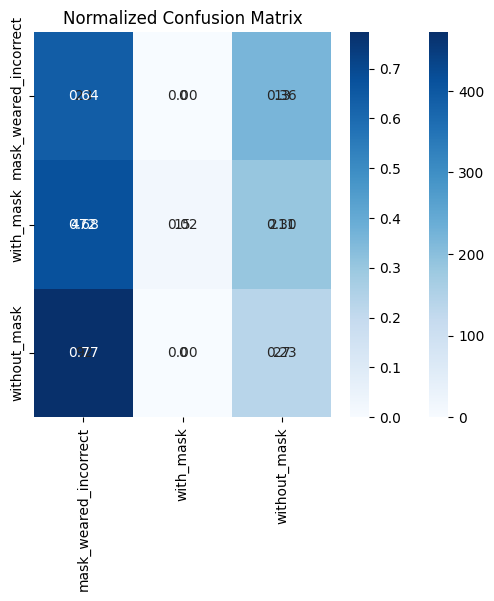

In [ ]:
# Evaluation
if not os.path.exists("../visualizations"):
    os.makedirs("../visualizations")

plot_training(history)
evaluate_model(model, test_gen)

# Ambil y_true dan y_pred dari prediksi
test_gen.reset()
preds = model.predict(test_gen, verbose=1)
y_pred = np.argmax(preds, axis=1)
y_true = test_gen.classes

save_predictions(y_true, y_pred, val_gen.class_indices)

In [52]:
loss, acc = model.evaluate(test_gen)
print(f"Test Loss: {loss:.4f}, Test Accuracy: {acc:.4f}")

27/27 [==============================] - 19s 683ms/step - loss: 2.6487 - accuracy: 0.0762
Test Loss: 2.6487, Test Accuracy: 0.0762


In [54]:
predict_single_image("../test/sample_test.png", model, train_gen.class_indices)

1/1 [==============================] - 1s 634ms/step
📌 Image: ../test/sample_test.png
Predicted: mask_weared_incorrect


In [60]:
# === YOLOv5 TESTING ===

print("\n🔍 Running YOLOv5 detection on sample image...")

# Load YOLOv5 pretrained model
# yolo_model = torch.hub.load('ultralytics/yolov5', 'yolov5s', pretrained=True)
yolo_model = torch.hub.load('ultralytics/yolov5', 'custom', path='../models/yolov5/yolov5s.pt')


# Load a sample image from the dataset (with_mask as example)
sample_images = glob.glob("../dataset/with_mask/*.jpg") + glob.glob("../dataset/with_mask/*.png")
if sample_images:
    test_img = sample_images[0]
    print("🖼️ Image path:", test_img)
    results = yolo_model(test_img)
    results.print()
    results.show()
else:
    print("❌ No image found in ../dataset/with_mask/")


🔍 Running YOLOv5 detection on sample image...


Using cache found in C:\Users\Ryan/.cache\torch\hub\ultralytics_yolov5_master
YOLOv5  2025-6-4 Python-3.11.5 torch-2.7.0+cpu CPU

100%|██████████| 14.1M/14.1M [00:02<00:00, 5.54MB/s]

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients, 16.4 GFLOPs
Adding AutoShape... 


❌ No image found in ../dataset/with_mask/


C:\Users\Ryan/.cache\torch\hub\ultralytics_yolov5_master\models\common.py:906: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
image 1/1: 400x267 1 person
Speed: 16.7ms pre-process, 102.9ms inference, 1.0ms NMS per image at shape (1, 3, 640, 448)



🖼️ Testing image from 'with_mask': ../dataset/with_mask\maksssksksss494.png


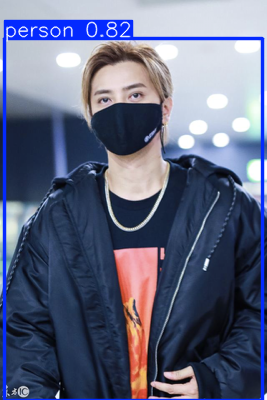


🖼️ Testing image from 'without_mask': ../dataset/without_mask\maksssksksss72.png


C:\Users\Ryan/.cache\torch\hub\ultralytics_yolov5_master\models\common.py:906: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
image 1/1: 400x301 1 person
Speed: 9.6ms pre-process, 194.1ms inference, 1.0ms NMS per image at shape (1, 3, 640, 512)


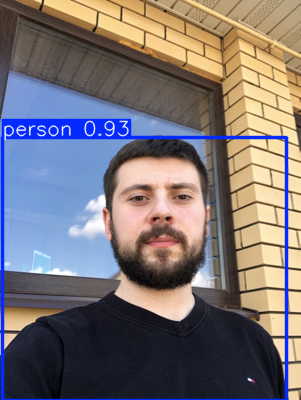

C:\Users\Ryan/.cache\torch\hub\ultralytics_yolov5_master\models\common.py:906: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
image 1/1: 210x400 2 persons
Speed: 12.3ms pre-process, 93.4ms inference, 1.0ms NMS per image at shape (1, 3, 352, 640)



🖼️ Testing image from 'mask_weared_incorrect': ../dataset/mask_weared_incorrect\maksssksksss406.png


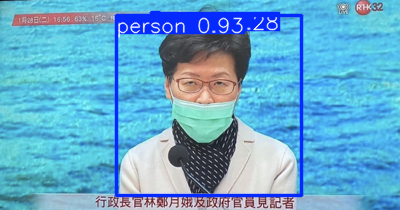

In [57]:
import random

for category in ['with_mask', 'without_mask', 'mask_weared_incorrect']:
    sample_images = glob.glob(f"../dataset/{category}/*.jpg") + glob.glob(f"../dataset/{category}/*.png")
    if sample_images:
        test_img = random.choice(sample_images)
        print(f"\n🖼️ Testing image from '{category}': {test_img}")
        results = yolo_model(test_img)
        results.print()
        results.show()
    else:
        print(f"❌ No image found in ../dataset/{category}/")